# Open MERRA-2 netCDF files from S3 storage as zarr stores using a pre-generated metadata reference files

## This notebook serves you:
1) Shared directory location of metadata reference files (.json)
2) Code for using the metadata reference files to read MERRA-2 netCDFs from S3 storage like zarr stores

### Import modules

In [1]:
import requests
import xarray as xr
import s3fs
from glob import glob
import fsspec

# The xarray produced from the reference file throws a SerializationWarning for each variable. Will need to explore why
import warnings
warnings.simplefilter("ignore")

### Get authentication and set up file system

In [2]:
gesdisc_s3 = "https://data.gesdisc.earthdata.nasa.gov/s3credentials"

response = requests.get(gesdisc_s3).json()
fs = s3fs.S3FileSystem(key=response['accessKeyId'],
                    secret=response['secretAccessKey'],
                    token=response['sessionToken'],
                    client_kwargs={'region_name':'us-west-2'})

### Define parameters for fsspec that include us-west-2 credentials

In [3]:
s_opts = {'skip_instance_cache':True}
r_opts = {'anon':False,
          'key':response['accessKeyId'],
          'secret':response['secretAccessKey'],
          'token':response['sessionToken']}

### Create a list of metadata references files containing metadata for one month (March 2019) of hourly MERRA-2 files from their location in a shared directory

In [8]:
reference_list = sorted(glob('/home/jovyan/shared/mapes/jsons/*.json'))
reference_list

['/home/jovyan/shared/mapes/jsons/MERRA2_400.tavg1_2d_slv_Nx.20190301.nc4.json',
 '/home/jovyan/shared/mapes/jsons/MERRA2_400.tavg1_2d_slv_Nx.20190302.nc4.json',
 '/home/jovyan/shared/mapes/jsons/MERRA2_400.tavg1_2d_slv_Nx.20190303.nc4.json',
 '/home/jovyan/shared/mapes/jsons/MERRA2_400.tavg1_2d_slv_Nx.20190304.nc4.json',
 '/home/jovyan/shared/mapes/jsons/MERRA2_400.tavg1_2d_slv_Nx.20190305.nc4.json',
 '/home/jovyan/shared/mapes/jsons/MERRA2_400.tavg1_2d_slv_Nx.20190306.nc4.json',
 '/home/jovyan/shared/mapes/jsons/MERRA2_400.tavg1_2d_slv_Nx.20190307.nc4.json',
 '/home/jovyan/shared/mapes/jsons/MERRA2_400.tavg1_2d_slv_Nx.20190308.nc4.json',
 '/home/jovyan/shared/mapes/jsons/MERRA2_400.tavg1_2d_slv_Nx.20190309.nc4.json',
 '/home/jovyan/shared/mapes/jsons/MERRA2_400.tavg1_2d_slv_Nx.20190310.nc4.json',
 '/home/jovyan/shared/mapes/jsons/MERRA2_400.tavg1_2d_slv_Nx.20190311.nc4.json',
 '/home/jovyan/shared/mapes/jsons/MERRA2_400.tavg1_2d_slv_Nx.20190312.nc4.json',
 '/home/jovyan/shared/mapes/

### Use fsspec to call upon the metadata reference files to extract metadata about S3 location and file structure and open as an xarray Dataset

The metadata reference files were pre-generated for you using the kerchunk library. It contains metadata for hourly MERRA-2 SLV files from March 2019 (31 days)

In [9]:
%%time

ds_k =[]
for ref in reference_list:
    s_opts = s_opts
    r_opts = r_opts
    fs = fsspec.filesystem("reference",
                           fo=ref,
                           ref_storage_args=s_opts,
                           remote_protocol='s3',
                           remote_options=r_opts)
    m = fs.get_mapper("")
    ds_k.append(xr.open_dataset(m, engine="zarr", backend_kwargs={'consolidated':False}, chunks={}))
    
ds_multi = xr.concat(ds_k, dim='time')
    
ds_multi

CPU times: user 5.65 s, sys: 189 ms, total: 5.84 s
Wall time: 10.5 s


,Array,Chunk
Bytes,590.15 MiB,51.19 kiB
Shape,"(744, 361, 576)","(1, 91, 144)"
Count,23839 Tasks,11904 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,590.15 MiB,51.19 kiB
Shape,"(744, 361, 576)","(1, 91, 144)"
Count,23839 Tasks,11904 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


### Plot temperature for the fifth time in the array

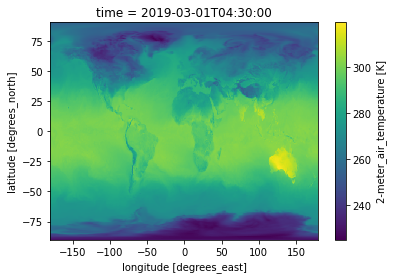

In [11]:
ds_multi.T2M[4,:,:].plot()